In [1]:
# task 4.1. Реализовать BiRNN & LSTM по предсказанию цены Bitcoin (или можете взять любой другой финансовый инструмент)

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


from keras import Model
from keras.layers import Input, Dense, Dropout
from keras.layers import LSTM, GRU

2024-10-27 23:09:22.787354: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [21]:
btc_data = pd.read_csv("btc_price.csv")
btc_data.head(3)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700


In [22]:
btc_data.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3228 entries, 0 to 3227
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       3228 non-null   object 
 1   Open       3228 non-null   float64
 2   High       3228 non-null   float64
 3   Low        3228 non-null   float64
 4   Close      3228 non-null   float64
 5   Adj Close  3228 non-null   float64
 6   Volume     3228 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 176.7+ KB


In [24]:
btc_data["Date"] = pd.to_datetime(btc_data["Date"])
btc_data = btc_data.sort_values(["Date"])

In [19]:
btc_data.tail(10)

,timestamp,open,high,low,close,volume,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume
9,2023-08-01 13:10:00,28872.48,28876.00,28870.00,28876.00,10.75734,3.105872e+05,381,7.87944,227495.165785
8,2023-08-01 13:11:00,28876.00,28881.54,28875.99,28881.54,6.85924,1.980829e+05,274,5.93315,171339.627576
7,2023-08-01 13:12:00,28881.54,28889.64,28881.53,28889.64,13.48153,3.894235e+05,500,11.58691,334697.039929
6,2023-08-01 13:13:00,28889.63,28890.40,28889.63,28890.39,17.87871,5.165159e+05,266,16.19349,467829.891694
5,2023-08-01 13:14:00,28890.40,28896.00,28890.39,28895.99,9.88869,2.857173e+05,389,5.46417,157873.630690
4,2023-08-01 13:15:00,28896.00,28907.42,28893.03,28907.41,37.74657,1.090761e+06,686,16.50452,476955.246611
3,2023-08-01 13:16:00,28907.41,28912.74,28907.41,28908.53,15.89610,4.595556e+05,483,10.22981,295738.166916
2,2023-08-01 13:17:00,28908.52,28908.53,28902.48,28902.49,11.52263,3.330532e+05,451,2.70873,78290.170121
1,2023-08-01 13:18:00,28902.48,28902.49,28902.48,28902.49,4.77589,1.380351e+05,317,2.24546,64899.385195
0,2023-08-01 13:19:00,28902.48,28902.49,28902.48,28902.49,4.68658,1.354538e+05,258,0.89391,25836.224836


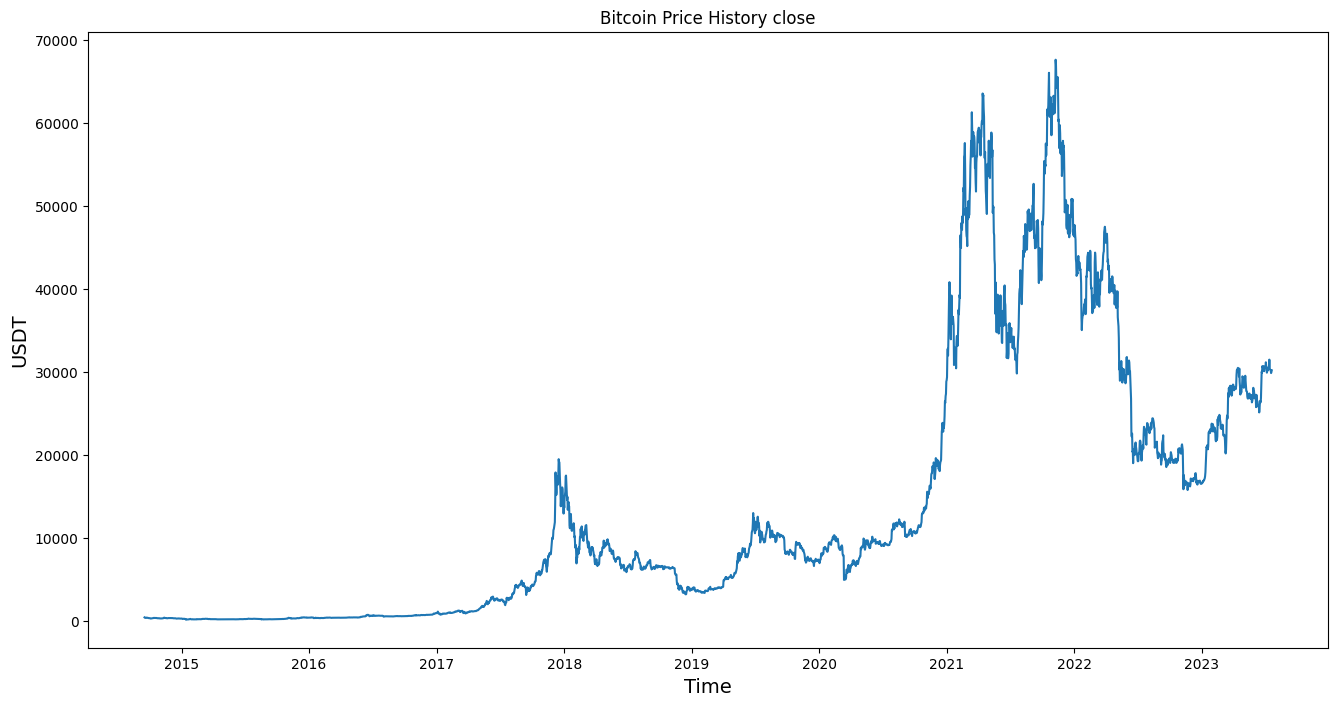

In [25]:
# Visualize the close price history
plt.figure(figsize=(16, 8))
plt.title("Bitcoin Price History close")
plt.plot(btc_data["Date"], btc_data["Close"])
plt.xlabel("Time", fontsize=14,)
plt.ylabel("USDT", fontsize=14)
plt.show()

In [27]:
# Предсказываем колнку close, как данные
btc_data.Date.dt.year.value_counts()

Date
2016    366
2020    366
2015    365
2017    365
2018    365
2019    365
2021    365
2022    365
2023    200
2014    106
Name: count, dtype: int64

In [29]:
btc_data = btc_data[btc_data.Date.dt.year >= 2017]

In [30]:
import math
# Create new data with only the "Close" column
close = btc_data.filter(["Close"])
# Convert the dataframe to a np array
close_array = close.values
# See the train data len
train_close_len = math.ceil(len(close_array) * 0.8)
train_close_len

1913

In [31]:
# Normalize the data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(close_array)
scaled_data

array([[0.00330246],
       [0.00365319],
       [0.00398393],
       ...,
       [0.43971463],
       [0.43538269],
       [0.44037362]])

In [34]:
train_data = scaled_data[0 : train_close_len, :]
# Create X_train and y_train
X_train = []
y_train = []
for i in range(30, len(train_data)):
    X_train.append(train_data[i - 30 : i, 0])
    y_train.append(train_data[i, 0])
    if i <= 30:
        print(X_train)
        print(y_train)
X_train, y_train = np.array(X_train), np.array(y_train)

[array([0.00330246, 0.00365319, 0.00398393, 0.00564423, 0.00352787,
       0.00186324, 0.00195882, 0.00199796, 0.00187263, 0.00194526,
       0.        , 0.00040541, 0.00069213, 0.00060871, 0.0006594 ,
       0.00080518, 0.00194914, 0.00162992, 0.0018164 , 0.00175581,
       0.00215652, 0.0021997 , 0.00214489, 0.00172079, 0.00185337,
       0.00209359, 0.00212599, 0.00215354, 0.00212219, 0.00213545])]
[0.0028843940005432063]


In [35]:
# reshape the data
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train.shape

(1883, 30, 1)

In [37]:
# create the testing dataset
test_data = scaled_data[train_close_len - 30 : , :]
# create X_test and y_test
X_test = []
y_test = btc_data.iloc[train_close_len : , :]
for i in range(30, len(test_data)):
    X_test.append(test_data[i - 30 : i, 0])

# convert the test data to a np array and reshape the test data
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [39]:
# Build the LSTM Model
from keras.models import Sequential
from keras.layers import Dense, LSTM

model = Sequential()

model.add(LSTM(units=512, return_sequences=True, activation='relu', input_shape=(X_train.shape[1], 1)))

model.add(LSTM(units=256, activation='relu', return_sequences=False))

model.add(Dense(units=1))

/usr/local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [40]:
model.compile(optimizer="Adam", loss="mean_squared_error", metrics=['mae'])
model.fit(X_train, y_train,
          epochs=3,
          batch_size=100,
          verbose=1)

Epoch 1/3
19/19 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - loss: 0.0635 - mae: 0.1544
Epoch 2/3
19/19 ━━━━━━━━━━━━━━━━━━━━ 18s 941ms/step - loss: 0.0022 - mae: 0.0319
Epoch 3/3
19/19 ━━━━━━━━━━━━━━━━━━━━ 16s 819ms/step - loss: 0.0013 - mae: 0.0221


In [41]:
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 223ms/step


/var/folders/yy/h36sr_t505d86h9cjh8p7lym0000gn/T/ipykernel_54771/2134383976.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid["Predictions"] = predictions


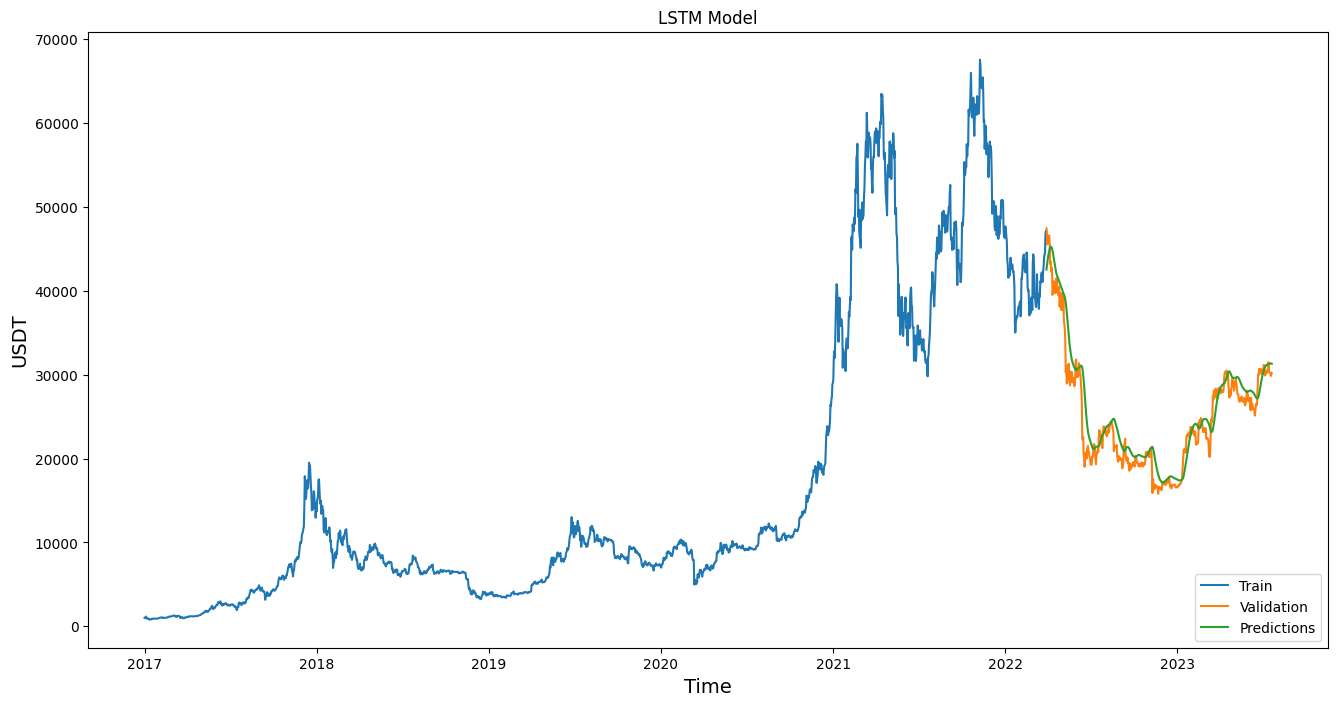

In [44]:
# plot the data
train = close[:train_close_len]
valid = close[train_close_len:]
valid["Predictions"] = predictions
#visualize the data
plt.figure(figsize=(16, 8))
plt.title("LSTM Model")
plt.xlabel("Time", fontsize=14)
plt.ylabel("USDT", fontsize=14)
plt.plot(btc_data["Date"][:train_close_len], train["Close"])
plt.plot(btc_data["Date"][train_close_len:], valid[["Close", "Predictions"]])
plt.legend(["Train", "Validation", "Predictions"], loc="lower right")
plt.show()
